# 목표
사용자 탐색

In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
# print(matplotlib.__file__)
import subprocess

mpl_file = matplotlib.__file__
mpl_file_loc = '/'.join(mpl_file.split('/')[:-1]) + '/mpl-data/fonts/ttf/'

# 폰트 복사

subprocess.run(f'cp /usr/share/fonts/truetype/nanum/Nanum* {mpl_file_loc}', shell=True)
print(mpl_file_loc)
subprocess.run('rm -rf ~/.cache/matplotlib/*', shell=True)
plt.rcParams["font.family"] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지
# 커널 재시작

/home/innovation/codessey/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/


In [2]:
class MovieDataLoader:
    def __init__(self, file_path = '../data'):
        self.file_path = file_path
        self.__load_data()

    def __load_data(self):
        for file_name in os.listdir(self.file_path):
            self.file_name = []
            if file_name.endswith('.csv'):
                setattr(self, os.path.splitext(file_name)[0], pd.read_csv(os.path.join(self.file_path, file_name)))
            if file_name.endswith('.txt'):
                setattr(self, os.path.splitext(file_name)[0], pd.read_csv(os.path.join(self.file_path, file_name), sep='\t', engine='python'))



In [3]:
movie_data_loader = MovieDataLoader()
casting = movie_data_loader.castings
countries = movie_data_loader.countries
genres = movie_data_loader.genres
movies = movie_data_loader.movies
peoples = movie_data_loader.peoples
rates = movie_data_loader.rates

outlier_min: -0.5, outlier_max: 3.5
over 10 rate movie ratio: 3.68%


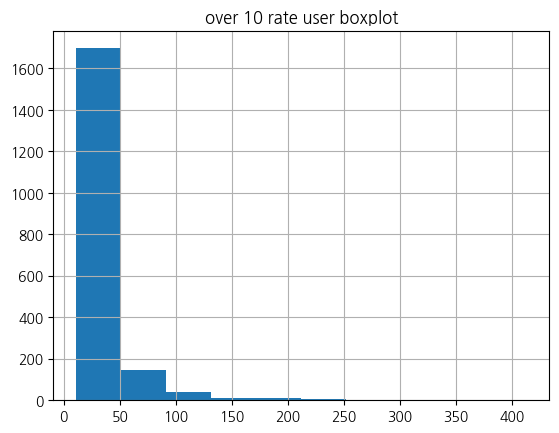

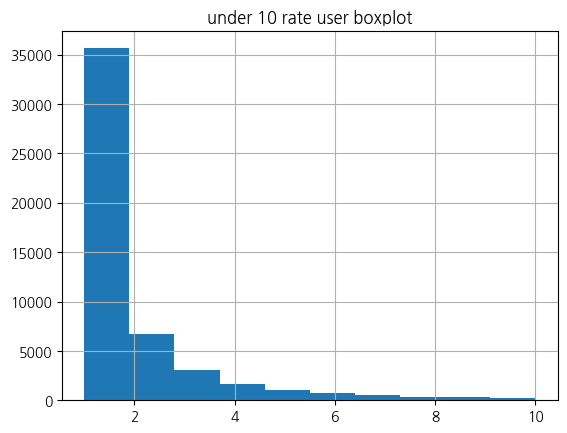

In [4]:
# 사용자별 몇 편의 영화에 평점을 남겼는지

rate_count = rates.groupby('user')['movie'].count().to_frame()
rate_count.columns = ['rate_count']
rate_count['rate_count'].describe()


# outlier using IQR method
q1 = rate_count['rate_count'].quantile(0.25)
q3 = rate_count['rate_count'].quantile(0.75)
iqr = q3 - q1
outlier_min = q1 - 1.5 * iqr
outlier_max = q3 + 1.5 * iqr

print(f'outlier_min: {outlier_min}, outlier_max: {outlier_max}')

# ouliner using Domain knowledge
outlier_max = 10
print(f'over 10 rate movie ratio: {rate_count[rate_count["rate_count"] > outlier_max].shape[0] / rate_count.shape[0] * 100:.2f}%')

# 평점을 많이 남긴 사용자의 영화 데이터만 추출
over_10_rate_user = rate_count[rate_count['rate_count'] > outlier_max]
under_10_rate_user = rate_count[rate_count['rate_count'] <= outlier_max]
over_10_rate_user.sort_values(by='rate_count', ascending=False).head(10)

plt.title("over 10 rate user boxplot")
plt.hist(over_10_rate_user['rate_count'], bins=10)
plt.grid()
plt.show()

plt.title("under 10 rate user boxplot")
plt.hist(under_10_rate_user['rate_count'], bins=10)
plt.grid()
plt.show()

In [5]:
# 사용자의 활동 패턴 탐색

## 사용자의 평점 주기

rate_time = rates.copy()
rate_time['timestamp'] = pd.to_datetime(rate_time['time'], unit='s')

def date_interval(timestamps):
    start = min(timestamps)
    end = max(timestamps)
    return (end - start).days

def activity(count, date_interval):
    return count / date_interval if date_interval != 0 else 0

rate_time_group_by_user = rate_time.groupby('user')['timestamp'].agg({'min', 'max', 'count', date_interval})
rate_time_group_by_user['activity'] = rate_time_group_by_user.apply(lambda row: activity(row['count'], row['date_interval']), axis=1)
rate_time_group_by_user.sort_values(by='date_interval', ascending=False).head(10)

,count,max,min,date_interval,activity
user,,,,,
1272,101,2019-11-19 22:54:00,2003-12-14 15:00:00,5819,0.017357
819,194,2019-10-27 06:02:00,2003-11-24 15:00:00,5815,0.033362
7828,13,2019-11-20 02:15:00,2003-12-24 15:00:00,5809,0.002238
44,375,2019-12-16 19:51:00,2004-01-24 18:22:00,5805,0.064599
1020,36,2019-10-10 20:47:00,2003-11-22 15:00:00,5801,0.006206
1502,59,2019-10-10 15:44:00,2003-12-14 15:00:00,5779,0.010209
6233,20,2019-09-17 15:19:00,2003-11-22 15:00:00,5778,0.003461
1181,29,2019-11-11 16:55:00,2004-01-17 15:00:00,5777,0.005020
532,63,2019-10-15 11:11:00,2003-12-24 15:00:00,5773,0.010913


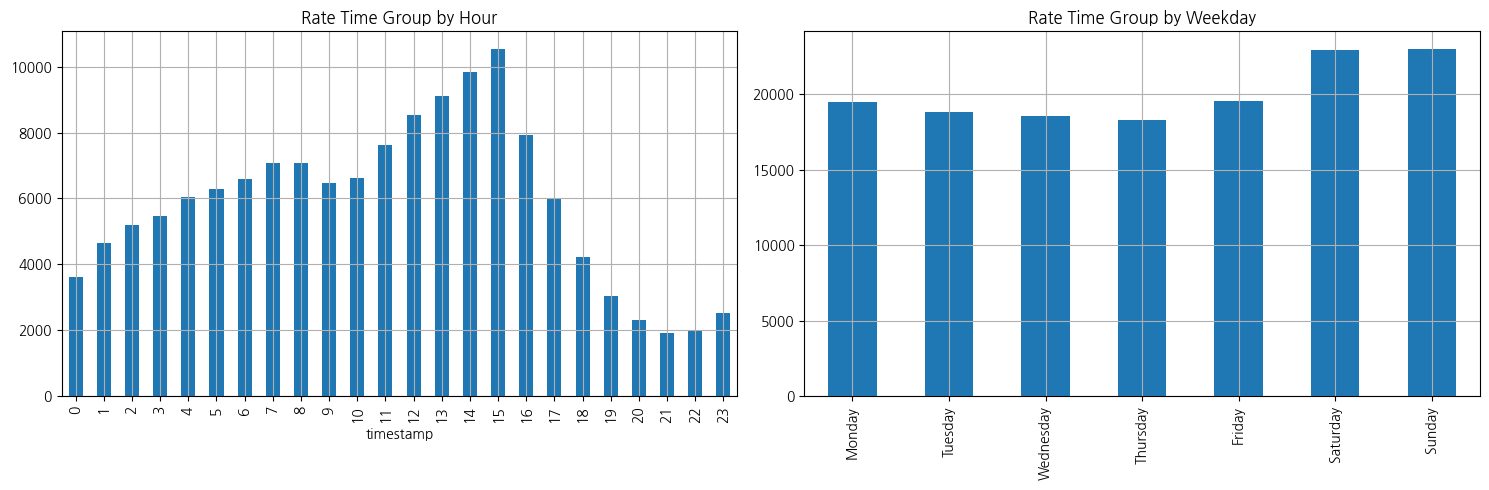

In [6]:
# 유저의 활동 패턴 탐색
## 평점을 남기는 시간대 탐색

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

rate_time_group_by_hour = rate_time['timestamp'].dt.hour.value_counts().sort_index()
rate_time_group_by_hour.plot(kind='bar', ax=axes[0])
axes[0].set_title('Rate Time Group by Hour')
axes[0].grid()

weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
rate_time_group_by_weekday = rate_time['timestamp'].dt.weekday.value_counts().sort_index()
rate_time_group_by_weekday.index = weekday_labels
rate_time_group_by_weekday.plot(kind='bar', ax=axes[1])
axes[1].set_title('Rate Time Group by Weekday')
axes[1].grid()

plt.tight_layout()
plt.show()


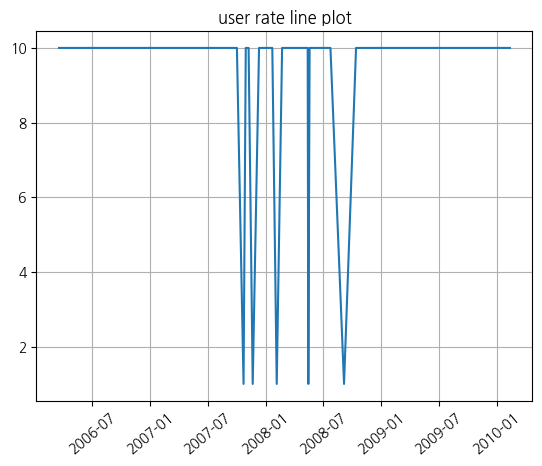

In [11]:
# 유저별 평점 분포

rates['date'] = pd.to_datetime(rates['time'], unit='s').dt.date
rates.head()
user_id = 42
user_rates = rates[rates['user'] == user_id].sort_values(by='date')
user_rates.head()

if (user_rates.shape[0] <= 1):
    print(f'user_id: {user_id} is only one rate or not exist')
else:
    plt.title("user rate line plot")
    plt.plot(user_rates['date'], user_rates['rate'],)
    plt.xticks(rotation=40)
    plt.grid()
    plt.show()

In [8]:
# 사용자 선호 장르 탐색

user_id = 0
user_info = rates[rates['user'] == user_id]
user_info = user_info.merge(movies[['movie', 'title']], on='movie')
# user_info = user_info.merge(genres, on='movie')
user_info.head()

,user,movie,rate,time,date,title
0,0,10003,7,1494128040,2017-05-07,빽 투 더 퓨쳐 2
1,0,10004,7,1467529800,2016-07-03,빽 투 더 퓨쳐 3
2,0,10018,9,1513344120,2017-12-15,이티
3,0,10021,9,1424497980,2015-02-21,록키
4,0,10022,7,1427627340,2015-03-29,록키 2
